In [1]:
import sys
# sys.path.insert(0, './multielectrode_grasp/code/python-neo')
sys.path.insert(0, './multielectrode_grasp/code/python-odml/')
sys.path.insert(0, './multielectrode_grasp/code/reachgraspio/')
import os
import neo
import quantities as pq
import reachgraspio
import elephant
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import gaussian_filter
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Load Data

In [2]:
session_name = os.path.join('./multielectrode_grasp', 'datasets', 'i140703-001')
odml_dir = os.path.join('./multielectrode_grasp/', 'datasets')

# Open the session for reading
session = reachgraspio.ReachGraspIO(session_name, odml_directory=odml_dir)

# Read the first 300s of data (time series at 1000Hz (ns2) and 30kHz (ns6)
# scaled to units of voltage, sorted spike trains, spike waveforms and events)
# from electrode 62 of the recording session and return it as a Neo Block. The
# time shift of the ns2 signal (LFP) induced by the online filter is
# automatically corrected for by a heuristic factor stored in the metadata
# (correct_filter_shifts=True).
block = session.read_block(
    nsx_to_load=2,
    n_starts=None, n_stops=20 * pq.s,
    channels=range(1, 97), units='all',
    load_events=True, load_waveforms=False, scaling='voltage',
    correct_filter_shifts=True)

## Function Definitions

In [3]:
def merge_analogsingals(asigs):
    min_length = np.min([len(asig.times) for asig in asigs])
    max_length = np.max([len(asig.times) for asig in asigs])
    if min_length != max_length:
        print('Warning: the length of the analog signals differs '\
            + 'between {} and {} '.format(min_length, max_length)\
            + 'All signals will be cut to the same length and merged '\
            + 'into one AnalogSignal object.')

    if len(np.unique([asig.sampling_rate for asig in asigs])) > 1:
        print([asig.sampling_rate for asig in asigs])
        raise ValueError('The AnalogSignal objects have different '\
                       + 'sampling rates!')

    asig_array = np.zeros((min_length, len(asigs)))

    for channel_number, asig in enumerate(asigs):
        asig_array[:, channel_number] = np.squeeze(asig.as_array()[:min_length])

    merged_asig = neo.AnalogSignal(asig_array*asigs[0].units,
                                sampling_rate=asigs[0].sampling_rate,
                                t_start=asigs[0].t_start)
    for key in asigs[0].annotations.keys():
        try:
            merged_asig.array_annotations[key] = np.array([a.annotations[key] for a in asigs])
        except:
            print('can not merge annotation ', key)
    return merged_asig

In [4]:
def AnalogSignal2ImageSequence(block):
    for seg_count, segment in enumerate(block.segments):
        block.segments[seg_count].imagesequences = []
        for asig_count, asig in enumerate(segment.analogsignals):
            asig_array = asig.as_array()
            dim_t, dim_channels = asig_array.shape

            if 'x_coords' not in asig.array_annotations\
                or 'y_coords' not in asig.array_annotations:
                print('AnalogSignal {} in Segment {} has no spatial Information '\
                      .format(asig_count, seg_count)\
                    + ' as array_annotations "x_coords" "y_coords", skip.')
                break

            coords = np.array([(x,y) for x,y in zip(asig.array_annotations['x_coords'],
                                                    asig.array_annotations['y_coords'])],
                              dtype=float)

            if len(coords) != dim_channels:
                raise IndexError("Number of channels doesn't agree with "\
                               + "number of coordinates!")

            dim_x = np.max(asig.array_annotations['x_coords']) + 1
            dim_y = np.max(asig.array_annotations['y_coords']) + 1

            image_data = np.empty((dim_t, dim_x, dim_y), dtype=asig.dtype)
            image_data[:] = np.nan

            for channel in range(dim_channels):
                x, y = coords[channel]
                x, y = int(x), int(y)
                image_data[:, x, y] = asig_array[:, channel]

            spatial_scale = asig.annotations['spatial_scale']

            # array_annotations = {}
            # for k, v in asig.array_annotations.items():
            #     array_annotations[k] = v.reshape((dim_x, dim_y))

            imgseq = neo.ImageSequence(image_data=image_data,
                                       units=asig.units,
                                       dtype=asig.dtype,
                                       # t_start=asig.t_start, # NotImplementedError
                                       sampling_rate=asig.sampling_rate,
                                       name=asig.name,
                                       description=asig.description,
                                       file_origin=asig.file_origin,
                                       # array_annotations=array_annotations,
                                       **asig.annotations)

            block.segments[seg_count].imagesequences.append(imgseq)
    return block

In [5]:
def channel2coords(channels, gridsize=(10,10)):
    channels -= 1
    x_coords = np.floor_divide(channels, gridsize[0])
    y_coords = np.remainder(channels, gridsize[1])
    return x_coords, y_coords

In [6]:
def smooth_frames(frames, sigma):
    # replace nan sites by median
    if np.isfinite(frames).any():
        # assume constant nan sites over time
        nan_sites = np.where(np.bitwise_not(np.isfinite(frames[0])))
        if np.iscomplexobj(frames):
            frames[:,nan_sites[0],nan_sites[1]] = np.nanmedian(np.real(frames)) \
                                                + np.nanmedian(np.imag(frames))*1j
        else:
            frames[:,nan_sites[0],nan_sites[1]] = np.nanmedian(frames)
    else:
        nan_sites = None

    # apply gaussian filter
    if np.iscomplexobj(frames):
        frames = gaussian_filter(np.real(frames), sigma=sigma, mode='nearest') \
               + gaussian_filter(np.imag(frames), sigma=sigma, mode='nearest')*1j
    else:
        frames = gaussian_filter(frames, sigma=sigma, mode='nearest')

    # set nan sites back to nan
    if nan_sites is not None:
        if np.iscomplexobj(frames):
            frames[:,nan_sites[0],nan_sites[1]] = np.nan + np.nan*1j
        else:
            frames[:,nan_sites[0],nan_sites[1]] = np.nan

    return frames

## Parse Metadata

In [7]:
asig = merge_analogsingals(block.segments[0].analogsignals)

In [8]:
x_coords, y_coords = channel2coords(asig.array_annotations['connector_aligned_id'])
asig.array_annotations['x_coords'] = x_coords
asig.array_annotations['y_coords'] = y_coords
asig.annotations['spatial_scale'] = 0.4 * pq.mm
asig.name = 'Raw Signal'

In [9]:
block.segments[0].analogsignals = [asig]

## Processing

In [10]:
freq_bands = {'Delta': ( 1,  4), 
              'Theta': ( 4,  8),
              'Alpha': ( 8, 12),
              'Beta' : (12, 25)}

### Frequency Filter & Hilbert Transform

In [11]:
raw_asig = block.segments[0].analogsignals[0]

for i, (name, (highpass, lowpass)) in enumerate(freq_bands.items()):
    block.segments[0].analogsignals.append(elephant.signal_processing.butter(
                                             raw_asig,
                                             highpass_freq=highpass*pq.Hz,
                                             lowpass_freq=lowpass*pq.Hz,
                                             order=2,
                                             filter_function='filtfilt')
                                          )
    asig = block.segments[0].analogsignals[-1]
    hilbert_asig = neo.AnalogSignal(signal=elephant.signal_processing.hilbert(asig),
                                    units='dimensionless',
                                    dtype=np.complex,
                                    t_start=asig.t_start, # NotImplementedError
                                    sampling_rate=asig.sampling_rate,
                                    name=name,
                                    highpass_freq=highpass,
                                    lowpass_freq=lowpass,
                                    **asig.annotations)
    hilbert_asig.array_annotations = asig.array_annotations
    block.segments[0].analogsignals[-1] = hilbert_asig

### Power Spectrum

In [12]:
freqs, psd = elephant.spectral.welch_psd(block.segments[0].analogsignals[0].time_slice(0*pq.s,1*pq.s),
                                         freq_res=1*pq.Hz,
                                         overlap=.7)

In [13]:
block = AnalogSignal2ImageSequence(block)

## Plotting functions

In [14]:
def plot_frame(frame, cmap=plt.cm.gray, vmin=None, vmax=None, colorbar=True, ax=None, 
               interpolate='cubic'):
    if ax is None:
        fig, ax = plt.subplots()
    if cmap is None:
        cmap = plot.cm.gray
    else:
        cmap = plt.get_cmap(cmap)
    
#     del_ids = np.array([0,9,90,99])
#     x = np.repeat(np.arange(dim_x), dim_y)
#     y = np.tile(np.arange(dim_y), dim_x)
#     x = np.delete(x, del_ids)
#     y = np.delete(y, del_ids)
#     print(frame.flatten()[del_ids])
#     frame = np.delete(frame.flatten(), del_ids)

    if interpolate is not None:
        dim_x, dim_y = frame.shape
        f = interp2d(np.arange(dim_x), np.arange(dim_y), np.nan_to_num(frame), kind='cubic')
        frame = f(np.arange(0, dim_x-1, .1), np.arange(0, dim_y-1, .1))
    
    img = ax.imshow(frame, interpolation='nearest',
                    cmap=cmap, vmin=vmin, vmax=vmax)
    if colorbar:
        plt.colorbar(img, ax=ax)
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_xlim((0, dim_x))
    # ax.set_ylim((dim_y, 0))
    return img

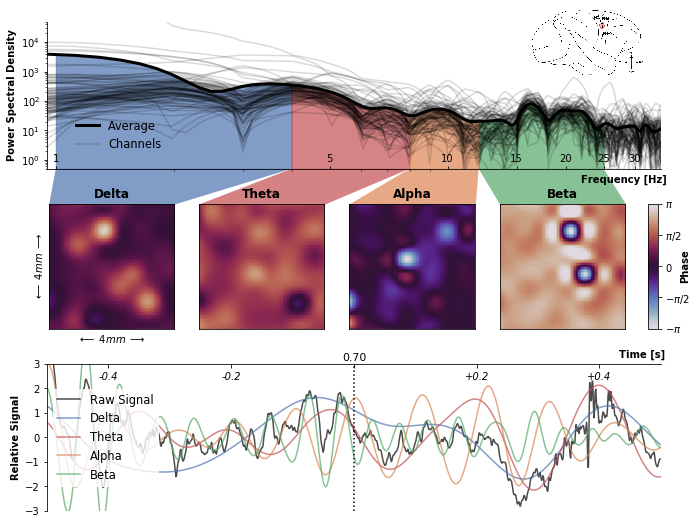

In [22]:
def plot_figure(frame_id, segment, t_window, cortex_img):
    fig = plt.figure(figsize=(11,9))
    gs = mpl.gridspec.GridSpec(nrows=3, ncols=5, width_ratios=[1,1,1,1,.1], height_ratios=[1,.85,1])
    gs.update(hspace=0.25)
    ax = [fig.add_subplot(gs[0, 0:]),
          fig.add_subplot(gs[2, 0:]),
          fig.add_subplot(gs[1, 0]),
          fig.add_subplot(gs[1, 1]),
          fig.add_subplot(gs[1, 2]),
          fig.add_subplot(gs[1, 3]),
          fig.add_subplot(gs[1, 4]),
         ]

    colors = ['k',
              '#4c72b0', # Delta
              '#c44e52', # Theta
              '#dd8452', # Alpha
              '#55a868'  # Beta
             ]
    alpha = .7

    raw_asig = segment.analogsignals[0]
    t = raw_asig.times[frame_id].rescale('s')
    tw_start = max([raw_asig.t_start.rescale('s'), t-t_window/2])
    tw_stop = tw_start + t_window
    if tw_stop > raw_asig.t_stop:
        tw_stop = raw_asig.t_stop
        tw_start = tw_stop - t_window

    # Frames
    for i, imgseq in enumerate(segment.imagesequences[1:]):
        frames = smooth_frames(imgseq.as_array(), .6)
        frame = np.angle(frames[frame_id])
        img = plot_frame(frame,
                         cmap='twilight',
                         ax=ax[i+2],
                         colorbar=False,
                         vmin=-np.pi,
                         vmax=np.pi,
                         interpolate='linear'
                        )
        ax[i+2].set_title(imgseq.name, weight='bold')
    ax[2].set_ylabel(r'$\longleftarrow\; 4mm\; \longrightarrow$')
    ax[2].set_xlabel(r'$\longleftarrow\; 4mm\; \longrightarrow$')

    # Colorbar
    ax[-1].set_axis_off()
    cax = ax[-1].inset_axes([0,0,.8,1])
    cbar = plt.colorbar(img, ax=ax[-1], cax=cax,
                        ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    cbar.set_label(label='Phase', weight='bold')
    cax.yaxis.labelpad = -10
    cbar.ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])

    # PSD
    xlim = (0.95, 35)
    ylim = (0.5 , 50000)
    ax[0].set_xlim(xlim)
    ax[0].set_ylim((ylim))
    ax[0].set_xlabel('Frequency [Hz]', weight='bold')
    ax[0].xaxis.set_label_coords(.94,-.04)
    ax[0].set_ylabel('Power Spectral Density', weight='bold')
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].yaxis.set_ticks_position('left')
    ax[0].xaxis.set_ticks_position('bottom')

    freqs, psd = elephant.spectral.welch_psd(raw_asig.time_slice(tw_start, tw_stop),
                                         freq_res=1/t_window,
                                         overlap=.7)

    xvalues = np.linspace(xlim[0], xlim[1], 200)
    avg_psd = np.mean(psd, axis=0)
    avg_psd_f = interp1d(freqs, avg_psd, kind='cubic')
    ax[0].loglog(xvalues, avg_psd_f(xvalues), linewidth=3,
                 color=colors[0], label='Average')
    for channel_psd in psd:
        f = interp1d(freqs, channel_psd, kind='slinear')
        ax[0].loglog(xvalues, f(xvalues), alpha=0.15,
                     color=colors[0], label='Channels')

    xfreqs = [1,5,10,15,20,25,30]
    ax[0].set_xticks(xfreqs)
    ax[0].set_xticklabels(xfreqs)
    ax[0].tick_params(axis="x",direction="in", pad=-15)
    handles, labels = ax[0].get_legend_handles_labels()

    ax[0].legend(handles[:2], labels[:2], frameon=False, fontsize=11.5,
                 loc=3, bbox_to_anchor=(.03, .05, 0.3, 0.3))

    # Freq areas
    trans = lambda a, x, y: fig.transFigure.inverted().transform(ax[a].transData.transform([x, y]))
    def add_polygon(ax2, x1, x3, color=None):
        ax1 = 0
        y1 = ylim[0]
        y2 = 0
        x2 = 1
        x4 = 89
        tx1, ty1 = trans(ax1, x1, y1)
        tx2, ty2 = trans(ax2, x2, y2)
        tx3, ty3 = trans(ax2, x4, y2)
        tx4, ty4 = trans(ax1, x3, y1)
        plyg = mpl.patches.Polygon(np.array([[tx1, tx2, tx3, tx4],
                                             [ty1, ty2, ty3, ty4]]).T,
                                   facecolor=color, zorder=0, alpha=alpha)
        fig.add_artist(plyg)

    # for i, (name, (highpass, lowpass)) in enumerate(freq_bands.items()):
    for i, asig in enumerate(segment.analogsignals[1:]):
        highpass = asig.annotations['highpass_freq']
        lowpass = asig.annotations['lowpass_freq']
        x = np.linspace(highpass, lowpass, 50)
        ax[0].fill_between(x, .5, avg_psd_f(x), color=colors[i+1], alpha=alpha)
        add_polygon(i+2, highpass, lowpass, color=colors[i+1])

    # Brain inset
    inax = ax[0].inset_axes([.63,.6,.5,.5])
    imgplot = inax.imshow(cortex_img)
    inax.set_axis_off()

    # Signal
    for i, asig in enumerate(block.segments[0].analogsignals):
        asig = asig.time_slice(tw_start, tw_stop)
        ax[1].plot(asig.times.rescale('s'),
                   zscore(np.nanmean(np.real(asig.as_array()), axis=1)),
                   alpha=alpha, label=asig.name, color=colors[i])
    ax[1].axvline(t, color='k', ls=':')
    xticks = np.linspace((t-t_window/2).magnitude,
                         (t+t_window/2).magnitude, 11)[1::2]
    xtl = np.round(xticks - t.magnitude, decimals=1)
    xticklabels = [f'{xtl[0]}',
                   f'{xtl[1]}',
                   '',
                   f'+{xtl[3]}',
                   f'+{xtl[4]}']
    ax[1].set_xticks(xticks)
    ax[1].set_xticklabels(xticklabels, fontstyle='italic')
    ax[1].set_title('{:.2f}'.format(np.round(t, decimals=2)),
                    y=.98, fontsize=11)
    ax[1].set_xlim((t-t_window/2).magnitude, (t+t_window/2).magnitude)
    ax[1].set_ylim((-3,3))
    ax[1].set_ylabel('Relative Signal', weight='bold')
    ax[1].set_xlabel('Time [s]', weight='bold')
    ax[1].xaxis.labelpad = 0
    ax[1].xaxis.set_ticks_position('top')
    ax[1].xaxis.set_label_position('top')
    ax[1].xaxis.set_label_coords(.97, 1.04)
    ax[1].tick_params(axis="x", direction="in", pad= -18)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].yaxis.set_ticks_position('left')
    legend = ax[1].legend(loc=6, fontsize=11.5)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('white')
    return fig


plot_figure(700, block.segments[0], 1*pq.s, mpl.image.imread('cortex_location.png'));

In [18]:
np.linspace(-.5, .5, 11)[1::2]

array([-0.4, -0.2,  0. ,  0.2,  0.4])